# Homework 4
### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

The flux vs. time plot below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile:

$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 

for $t>T$ (recall Week-5-Thu lecture).

Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts.

**Hints:**
- You can relatively easily solve this problem by generalizing the code from [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)
- There are no more than 2 bursts in this dataset. I.e., you can fit a single-burst model, and then a double-burst model, and then compare which one fits better. Show the posteriors plots (like in [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)) for both models.
- You can use flat priors for A and T and the background (non-bursting) flux level, and Jeffreys' prior, $p(\alpha) \propto \alpha^{-1}$, for $\alpha$
- You can do approximate model comparison based on the BIC 

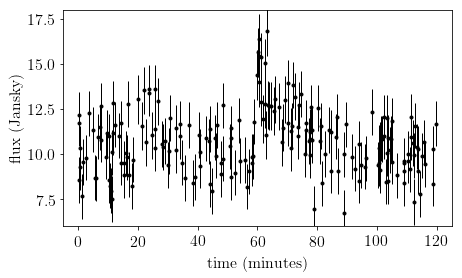

In [25]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import pymc
%matplotlib inline

# read data
data = np.loadtxt('data/HW4dataFinal.txt', unpack=True)
t,y_obs,sigma_y = data
N=len(t)
# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('time (minutes)')
ax.set_ylabel(r'flux (Jansky)')

plt.show()

## Solution

In [162]:
### AstroML book figure 10.25

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

# Hack to fix import issue in older versions of pymc
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc

from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=16, usetex=True)


#----------------------------------------------------------------------
# Set up toy dataset
def multiburst(t,y_obs,sigma_y,b0=None):
    def burst(t, b0, A, alpha, T):
        """Burst model"""
        y = np.empty(t.shape)
        y.fill(b0)
        mask = (t >= T)
        y[mask] += A * np.exp(-alpha * (t[mask] - T))
        return y

    np.random.seed(10)
    N = len(t) 
    sigma=1.0
    # Generate the burst data -- true burst + some background


    #----------------------------------------------------------------------
    # Set up MCMC sampling
    b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
    A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
    T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
    log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)

    # uniform prior on log(alpha)
    @pymc.deterministic
    def alpha(log_alpha=log_alpha):
        return 1/np.exp(log_alpha)

    @pymc.deterministic
    def y_model(t=t, b0=b0, A=A, alpha=alpha, T=T):
        return burst(t, b0, A, alpha, T)

    y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

    model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
                 alpha=alpha, y_model=y_model, y=y)


    #----------------------------------------------------------------------
    # Run the MCMC sampling
    # @pickle_results('matchedfilt_burst.pkl')
    def compute_MCMC_results(niter=25000, burn=4000):
        S = pymc.MCMC(model)
        S.sample(iter=niter, burn=burn)
        traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

        M = pymc.MAP(model)
        M.fit()
        fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

        return traces, fit_vals

    traces, fit_vals = compute_MCMC_results()

    labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
    # limits = [(9.2, 11.2), (2, 12), (45, 55), (0.0, 0.25)]
#     limits = [(9.7, 10.7), (3, 7), (58, 61), (0.05, 0.18)]

    #------------------------------------------------------------
    # Plot the results
    # plot data
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
    fig.subplots_adjust(bottom=0.1, top=0.95,
                        left=0.1, right=0.95,
                        hspace=0.05, wspace=0.05)

    obs=[b0,A,T,alpha]

    # This function plots multiple panels with the traces
    plot_mcmc(traces, labels=labels,true_values=obs, fig=fig,
              bins=30, colors='k')

    # Plot the model fit
    ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
    t_fit=t
    y_fit = burst(t_fit, *fit_vals)
    print(*fit_vals)

    ax.scatter(t, y_obs, s=9, lw=0, c='k')
    ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
    ax.plot(t_fit, y_fit, '-k', c='red')
    # ax.set_xlim(0, 100)
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$h_{\rm obs}$')
    plt.axvline(x=T)
    plt.show()
    return y_fit,t_fit,(*fit_vals)

 [-----------------100%-----------------] 25000 of 25000 complete in 6.3 sec10.180553644203089 3.3666305514809456 0.209218037024 21.591550891497445


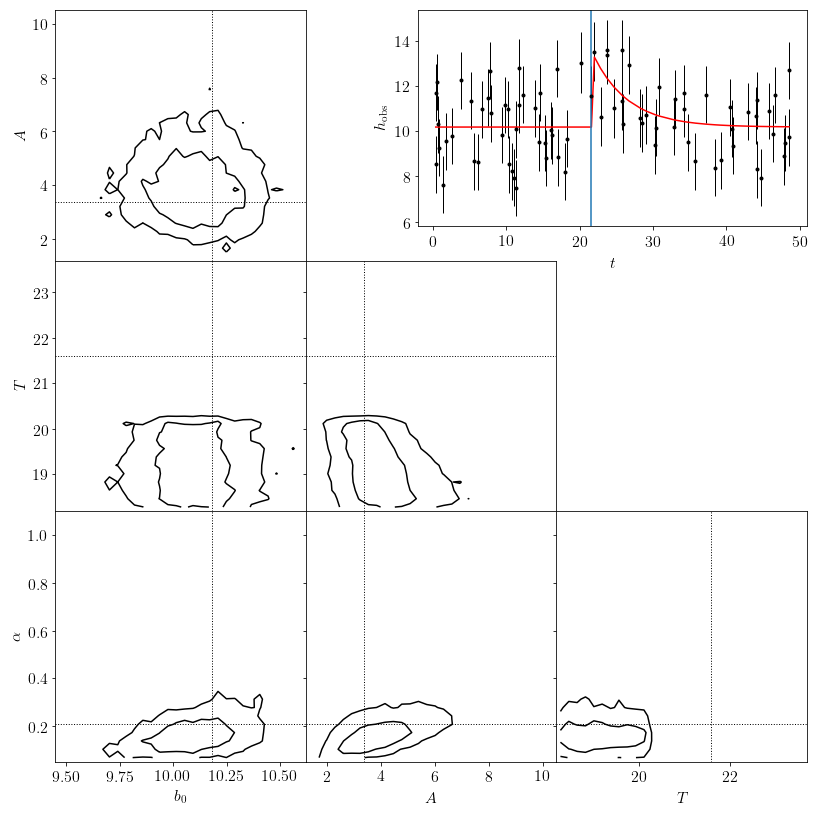

 [-----------------100%-----------------] 25000 of 25000 complete in 7.0 sec10.233149200626737 5.189468815645635 0.108801227617 59.08491168205002


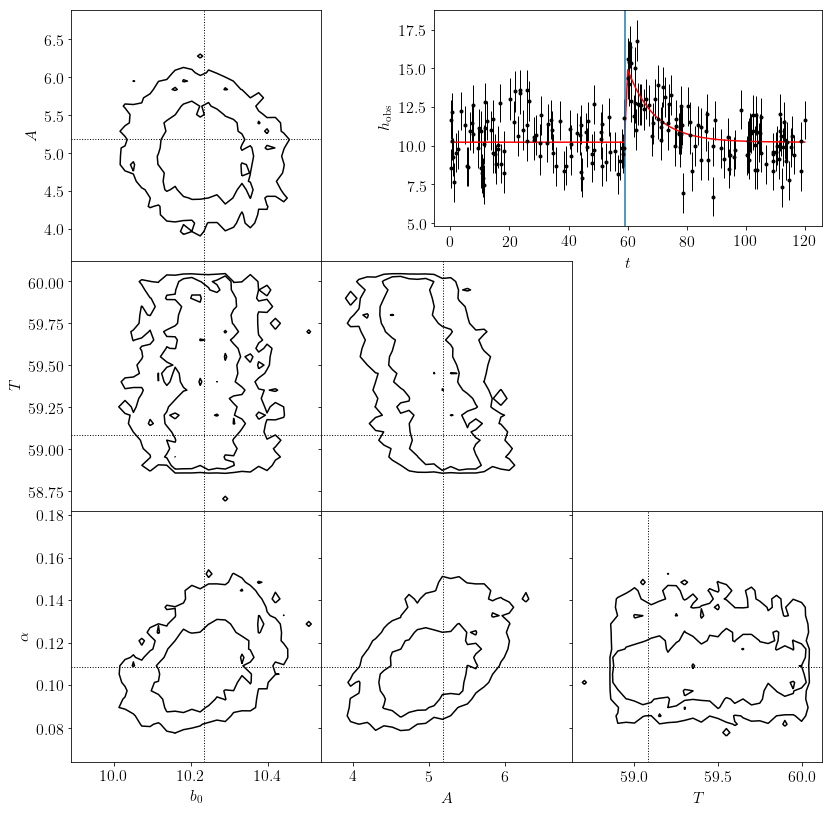

In [163]:
cond1=(t<=50)
burst1,tfit1,b01,A1,alpha1,T1=multiburst(t[cond1],y_obs[cond1],sigma_y[cond1])
cond2=(t>0)
burst2,tfit2,b02,A2,alpha2,T2=multiburst(t[cond2],y_obs[cond2],sigma_y[cond2])

10.180553644203089 10.233149200626737 21.591550891497445 59.08491168205002
240.54652569 261.739795156
218.695615252 239.888884718


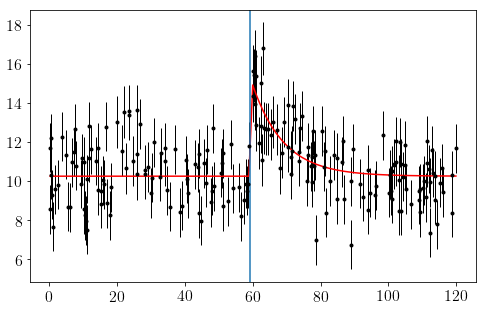

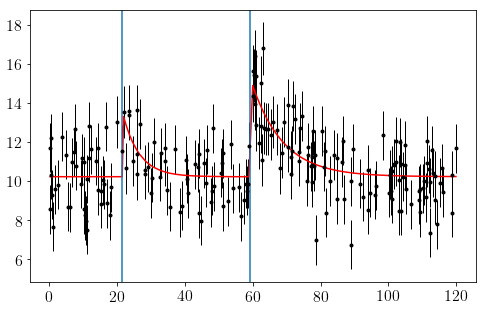

In [165]:
fig = plt.figure(figsize=(8, 5))
ax = plt.subplot()
ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(tfit2, burst2, '-k', c='red')
plt.axvline(x=T2)

chi2=np.sum(((y_obs-burst2)/sigma_y)**2)
bic=chi2+4*np.log(len(burst2))
print("SINGLE BURST MODEL")
print(chi2,bic)

burst=np.concatenate((burst1-b01,burst2[(tfit2>50)]-b02))+(b01+b02)/2.
t_fit=np.concatenate((tfit1,tfit2[tfit2>50]))
fig = plt.figure(figsize=(8, 5))
ax = plt.subplot()
ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.plot(t_fit, burst, '-k', c='red')
plt.axvline(x=T1)
plt.axvline(x=T2)

# print(len(y_obs),len(burst),len(sigma_y))
chi2=np.sum(((y_obs-burst)/sigma_y)**2)
bic=chi2+4*np.log(len(burst))
print(chi2,bic)

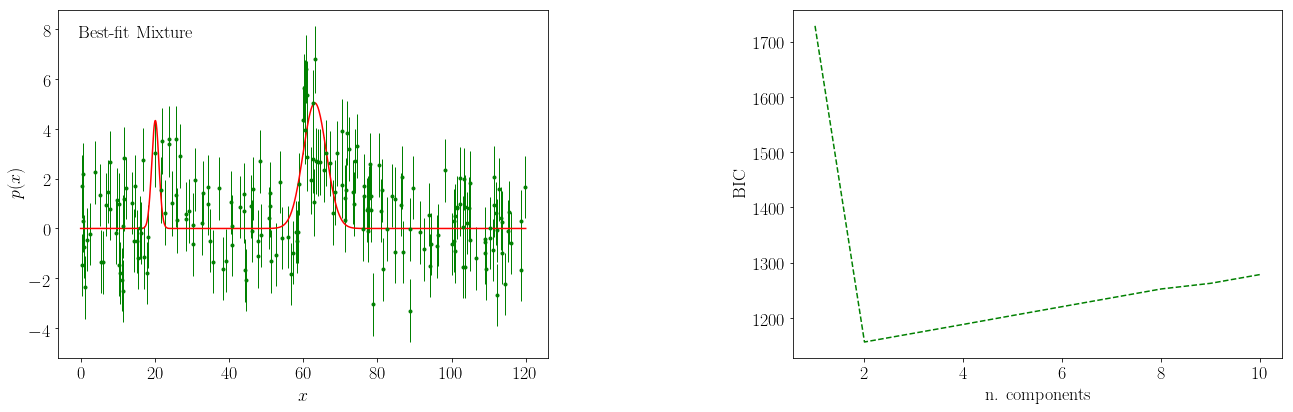

In [72]:
### Modeled after astroML book figure 4.2  
import warnings
warnings.filterwarnings('ignore')
from sklearn.mixture import GMM
setup_text_plots(fontsize=18, usetex=True)

def doGMM(Ndata, noiseStd=0.00000001):
    #------------------------------------------------------------
    # Set up the dataset.
    #  We'll use scikit-learn's Gaussian Mixture Model to sample
    #  data from a mixture of Gaussians.  The usual way of using
    #  this involves fitting the mixture to data: we'll see that
    #  below.  Here we'll set the internal means, covariances,
    #  and weights by-hand.
    np.random.seed(1)
    gmm = GMM(2, n_iter=1)
    gmm.means_ = np.array([[20], [63]])
    gmm.covars_ = np.array([[1], [3]]) ** 2
    gmm.weights_ = np.array([0.15,0.85])
    X = gmm.sample(Ndata)
    #------------------------------------------------------------
    # Learn (train) the best-fit GMM models
    # Here we'll use GMM in the standard way: the fit() method
    # uses an Expectation-Maximization approach to find the best
    # mixture of Gaussians for the data

    # fit models with 1-10 components
    N = np.arange(1, 11)
    models = [None for i in range(len(N))]
    
    for i in range(len(N)):
        models[i] = GMM(N[i]).fit(X)

    # compute the BIC
    BIC = [m.bic(X) for m in models]

    #------------------------------------------------------------
    # Plot the results
    #  We'll use two panels:
    #   1) data + best-fit mixture
    #   2) BIC vs number of components 

    fig = plt.figure(figsize=(20, 7))
    fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


    # plot 1: data + best-fit mixture
    ax = fig.add_subplot(121)
    M_best = models[np.argmin(BIC)]

    x = np.linspace(0, 120, 1000)
    logprob, responsibilities = M_best.score_samples(x.reshape((-1,1))) ## fix
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

   
    ax.errorbar(t, y_obs-10.0, sigma_y, fmt='.', lw=1, c='g')
    ax.plot(x, 50*pdf ,'-r')
    ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')


    # plot 2: BIC
    ax = fig.add_subplot(122)
    ax.plot(N, BIC, '--g')
    ax.set_xlabel('n. components')
    ax.set_ylabel('BIC')

    plt.show()
    
doGMM(N)    